In [1]:
# considera solo le probabilità superiori a:
min_prob = 0.98

# ----------------------------------------------------------------------- #
# seleziona un'immagine e la dimensione con la quale la vuoi caricare     #
# ----------------------------------------------------------------------- #

#fname = '/notebooks/images/test_fcn/signs.jpeg'
#IMAGE_SIZE_NEW = (600, 1000)

#fname = '/notebooks/images/test_fcn/signs_2.jpeg'
#IMAGE_SIZE_NEW = (293, 222)

#name = '/notebooks/images/test_fcn/signs_3.jpeg'
#IMAGE_SIZE_NEW = (64, 64)

#fname = '/notebooks/images/test_fcn/signs_5.jpeg'
#IMAGE_SIZE_NEW = (576, 992)

#fname = '/notebooks/images/test_fcn/signs_6.jpeg'
#IMAGE_SIZE_NEW = (600, 1000)

#fname = '/notebooks/images/test_fcn/signs_7.jpeg'

#IMAGE_SIZE_NEW = (600, 1000)

#fname = '/notebooks/images/test_fcn/signs_4.jpeg'
#IMAGE_SIZE_NEW = (int(1770/5), int(2717/5))

#fname = '/notebooks/images/test_fcn/2.png'
#IMAGE_SIZE_NEW = (32, 32)

#fname = '/notebooks/images/test_fcn/7.png'
#fname = '/notebooks/images/test_fcn/10.png'
#fname = '/notebooks/images/test_fcn/17.png'
#fname = '/notebooks/images/test_fcn/35.png'
fname = '/notebooks/images/test_fcn/86.png'
IMAGE_SIZE_NEW = (720/2, 1280/2)

#fname = '/notebooks/images/test_fcn/00034d.ppm'
#IMAGE_SIZE_NEW = (190, 400)

#fname = '/notebooks/images/test_fcn/00034.ppm'
#IMAGE_SIZE_NEW = (36, 36)

In [2]:
import sys
import scipy
import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian

import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

import my_mod_load as load
import my_mod_manipulate_image as manipulate
import numpy as np
import settings


from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import keras

import matplotlib.pyplot as plt


# load e normalizzazioen dell'immagine
img = io.imread(fname)
img = transform.resize(img, IMAGE_SIZE_NEW, order=3)
img_original = img

img = gaussian(img,.6,multichannel=True)*255
img = manipulate.normalize_img(img.astype(np.uint8))
img.shape = (1,) + img.shape

# print dell'immagine originale
plt.imshow(np.array(img_original.squeeze()))

/Miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
def to_fully_conv(model):

    new_model = Sequential()

    input_layer = InputLayer(input_shape=(None, None, 1), name="input_new")

    new_model.add(input_layer)

    for layer in model.layers:

        if "Flatten" in str(layer):
            flattened_ipt = True
            f_dim = layer.input_shape
            #print("flatten")

        elif "Dense" in str(layer):

            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()

            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                #print("dimensioni nuovo kernel: ")
                #print(f_dim[1])
                #print(f_dim[2])
                new_layer = Convolution2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b],
                                          name=layer.name+"_x")
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (1,1),
                                          strides=(1, 1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b],
                                          name=layer.name+"_x")


        else:
            new_layer = layer

        #print(layer.name + "   " + new_layer.name)
        new_model.add(new_layer)

    return new_model



In [4]:
model = '/notebooks/final_models/keras/2018-02-23_1203/model_108-108-100_ep40'
# model = '/notebooks/final_models/keras/2018-02-24_1111/model_108-108-100_ep40'


json_file = open("{}.json".format(model), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("{}.h5".format(model))

loaded_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 108)       1080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 108)       105084    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 108)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 108)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 108)       105084    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 108)       105084    
__________

In [5]:
new_model = Sequential()
input_layer = InputLayer(input_shape=(None, None, 1), name="input_new")
new_model.add(input_layer)

new_model.add(loaded_model.get_layer("conv2d_1"))
new_model.add(loaded_model.get_layer("conv2d_2"))
new_model.add(loaded_model.get_layer("max_pooling2d_1"))
new_model.add(loaded_model.get_layer("dropout_1"))
new_model.add(loaded_model.get_layer("conv2d_3"))
new_model.add(loaded_model.get_layer("conv2d_4"))
new_model.add(loaded_model.get_layer("max_pooling2d_3"))
new_model.add(loaded_model.get_layer("dropout_2"))

# first dense layer
flatten_layer = loaded_model.get_layer("flatten_1")
flatten_dim = flatten_layer.input_shape
print(flatten_dim)

dense_layer = loaded_model.get_layer("dense_1")
input_shape_dense = dense_layer.input_shape
print(input_shape_dense)
output_dim_dense =  dense_layer.get_weights()[1].shape[0]
print(output_dim_dense)
W, b = dense_layer.get_weights()
shape = (flatten_dim[1], flatten_dim[2], flatten_dim[3], output_dim_dense)
print(shape)
new_W = W.reshape(shape)
print("dimensioni nuovo kernel: ")
print(flatten_dim[1])
print(flatten_dim[2])
new_layer = Convolution2D(output_dim_dense,
                         (flatten_dim[1], flatten_dim[2]),
                         strides=(1, 1),
                         activation=dense_layer.activation,
                         padding='valid',
                         weights=[new_W, b],
                         name="conv2d_x1")
new_model.add(new_layer)

new_model.add(loaded_model.get_layer("dropout_3"))

# second dense layer
dense_layer = loaded_model.get_layer("dense_2")
input_shape_dense = dense_layer.input_shape
print(input_shape_dense)
output_dim_dense =  dense_layer.get_weights()[1].shape[0]
print(output_dim_dense)
W, b = dense_layer.get_weights()
shape = (1, 1, input_shape_dense[1], output_dim_dense)
new_W = W.reshape(shape)
new_layer = Convolution2D(output_dim_dense,
                          (1, 1),
                          strides=(1, 1),
                          activation=dense_layer.activation,
                          padding='valid',
                          weights=[new_W, b],
                          name="conv2d_x2")
new_model.add(new_layer)

print(new_model.summary())

(None, 5, 5, 108)
(None, 2700)
100
(5, 5, 108, 100)
dimensioni nuovo kernel: 
5
5
(None, 100)
43
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_new (InputLayer)       (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1080      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  105084    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  105084    
_____________________________________________

In [6]:
predicted_proba = new_model.predict(img)
print("dimensione dell'otuput")
print(predicted_proba.shape)

dimensione dell'otuput
(1, 83, 153, 43)


In [7]:
#from convnetskeras.imagenet_tool import synset_to_dfs_ids
## Test pretrained model
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
##model = convnet('alexnet', weights_path='weights/alexnet_weights.h5', heatmap=True)
#new_model.compile(optimizer=sgd, loss='mse')
#
#out = new_model.predict(img)
#
#s = 'n06794110'
## Most of the synsets are not in the subset of the synsets used in ImageNet recognition task.
#ids = np.array([id_ for id_ in synset_to_dfs_ids(s) if id_ is not None])
#heatmap = out[0, ids, :, :].sum(axis=0)

TypeError: Invalid dimensions for image data

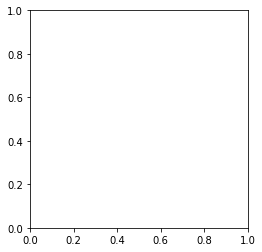

AssertionError: For now, the function only works with less than 11 channels

In [22]:
# it's height, width in TF - not width, height
# new_height = int(round(224))
# new_width = int(round(224))
#
# resized = tf.image.resize_images(predicted_proba, [new_height, new_width])
# print(resized.shape)
print("dimensione immagine originale x,y e dimensione output x,y")

print(IMAGE_SIZE_NEW[0])
print(IMAGE_SIZE_NEW[1])
num_1 = predicted_proba.shape[1]
num_2 = predicted_proba.shape[2]
print(num_1)
print(num_2)

resized = scipy.ndimage.zoom(predicted_proba, (1,IMAGE_SIZE_NEW[0]/predicted_proba.shape[1],
                                               IMAGE_SIZE_NEW[1]/predicted_proba.shape[2], 1), order=0)
#resized = scipy.ndimage.zoom(predicted_proba, (1,32,32,1), order=1)
print(resized.shape)


original_matrix = [[0 for x in range(num_2)] for y in range(num_1)]
m = 0
for i in range(0, num_1):
    for j in range(0, num_2):
        a = predicted_proba[0][i][j]
        max_prob = max(a)
        for i1, j1 in enumerate(a):
             if j1 == max_prob:
                #original_matrix[i][j] = i1
                if max_prob >= min_prob:
                    #print("{}       {}".format(i1, max_prob))
                    original_matrix[i][j] = i1
                else:
                    original_matrix[i][j] = -255
                
                
                
#print(predicted_proba)
#print(resized.shape[2])
num_1 = resized.shape[1]
num_2 = resized.shape[2]
new_matrix = [[0 for x in range(num_2)] for y in range(num_1)]
m = 0
for i in range(0, num_1):
    for j in range(0, num_2):
        a = resized[0][i][j]
        max_prob = max(a)
        for i1, j1 in enumerate(a):
             if j1 == max_prob:
                #new_matrix[i][j] = i1
                if max_prob >= min_prob:
                    new_matrix[i][j] = i1
                else:
                    new_matrix[i][j] = -255
                    


        # top1 = np.sort(resized[0][i][j])[42]
        # if(top1 >= 0.8):
        #     #print(top1)
        #     m+=1

dimensione immagine originale x,y e dimensione output x,y
360.0
640.0
83
153
(1, 360, 640, 43)


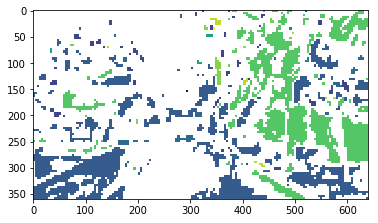

In [23]:
# print(new_matrix)
# from pylab import *
# A = rand(5,5)
#figure(1)
new_matrix = np.array(new_matrix)
new_matrix = np.ma.masked_where(new_matrix < 0, new_matrix)
plt.imshow(new_matrix)
#grid(True)

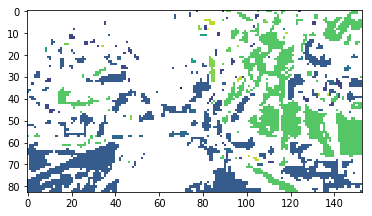

In [198]:
original_matrix = np.array(original_matrix)
original_matrix = np.ma.masked_where(original_matrix < 0, original_matrix)
plt.imshow(original_matrix)

In [199]:
np.set_printoptions(threshold=np.nan)
#print(original_matrix)

In [200]:
#from collections import Counter
#count = Counter(original_matrix)
#Counter({'a': 2, 'c': 2, 'b': 1, 'd': 1})
#count.most_common()
#print(original_matrix)

In [201]:
#new_matrix = np.array(new_matrix)
#new_matrix = (new_matrix/255)
#print(new_matrix[40])

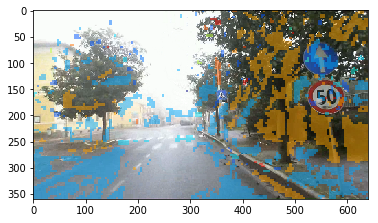

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generate some data...
#gray_data = np.arange(10000).reshape(100, 100)

#masked_data = np.random.random(IMAGE_SIZE_NEW)

masked_data = np.ma.masked_where(new_matrix < 0, new_matrix)
#masked_data = np.dot(masked_data, 1000)
# Overlay the two images
fig, ax = plt.subplots()
ax.imshow(img_original, cmap=cm.gray)
ax.imshow(masked_data, cmap=cm.jet, alpha=0.5)
plt.show()

In [203]:
labels = np.unique(original_matrix)
for l in labels:
    print(load.get_name_from_label(l))
# print(np.unique(original_matrix))

Speed limit (70km/h)
No passing for vehicles over 3.5 metric tons
Priority road
Yield
No vehicles
No entry
General caution
Dangerous curve to the right
Traffic signals
End of all speed and passing limits
Turn right ahead
Turn left ahead
Ahead only
Go straight or right
Keep right
End of no passing by vehicles over 3.5 metric tons


TypeError: len() of unsized object